In [12]:
# Cellule 1: Installation des dépendances nécessaires
# =============================================================================
# CONFIGURATION DE L'ENVIRONNEMENT
# =============================================================================

# Note: Exécuter cette cellule en premier pour installer toutes les dépendances

!pip install tensorflow scikit-learn nltk seaborn matplotlib faiss-cpu sentence-transformers

print("✅ Toutes les dépendances sont installées!")

✅ Toutes les dépendances sont installées!


In [13]:
# Cellule 2: Import des bibliothèques
# =============================================================================
# IMPORT DES BIBLIOTHÈQUES
# =============================================================================

# Deep Learning et ML
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Data manipulation et visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP et preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# RAG et embeddings
import faiss
import pickle
from sentence_transformers import SentenceTransformer

# Configuration
import warnings
warnings.filterwarnings('ignore')

print("✅ Toutes les bibliothèques sont importées!")

✅ Toutes les bibliothèques sont importées!


In [14]:
# Cellule 3: Téléchargement des ressources NLTK
# =============================================================================
# TÉLÉCHARGEMENT DES RESSOURCES NLP
# =============================================================================

# Téléchargement des ressources nécessaires pour NLTK
try:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('punkt_tab') # Added punkt_tab download
    print("✅ Ressources NLTK téléchargées avec succès!")
except Exception as e:
    print(f"⚠️ Erreur lors du téléchargement NLTK: {e}")

✅ Ressources NLTK téléchargées avec succès!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [15]:
# Cellule 4: Chargement et exploration des données
# =============================================================================
# CHARGEMENT ET EXPLORATION DES DONNÉES
# =============================================================================

print("📊 CHARGEMENT DES DONNÉES...")

# Chargement du dataset
resumeDataSet = pd.read_csv('../content/UpdatedResumeDataSet.csv', encoding='utf-8')

# Affichage des informations de base
print(f"📈 Nombre total de CVs: {len(resumeDataSet)}")
print(f"🏷️ Nombre de catégories: {resumeDataSet['Category'].nunique()}")
print(f"📝 Colonnes disponibles: {list(resumeDataSet.columns)}")

# Aperçu des données
print("\n🔍 Aperçu des données:")
print(resumeDataSet.head())

print("\n📊 Distribution des catégories:")
print(resumeDataSet['Category'].value_counts())

📊 CHARGEMENT DES DONNÉES...
📈 Nombre total de CVs: 962
🏷️ Nombre de catégories: 25
📝 Colonnes disponibles: ['Category', 'Resume']

🔍 Aperçu des données:
       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...

📊 Distribution des catégories:
Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager  

📊 CRÉATION DES VISUALISATIONS...


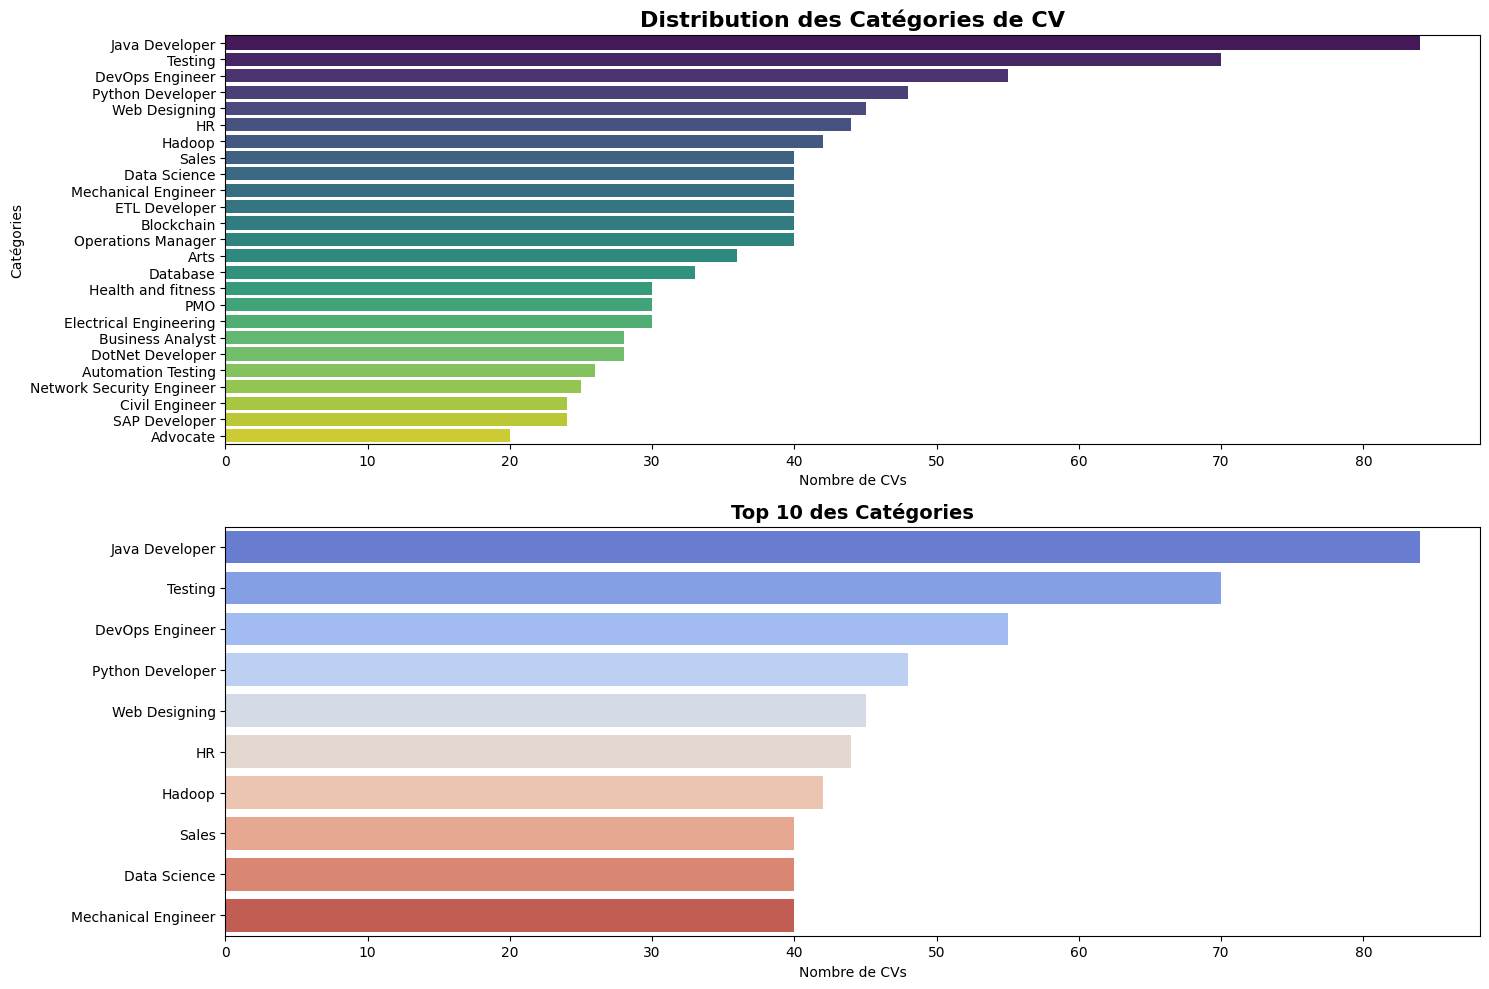

🎯 Catégorie la plus représentée: Java Developer (84 CVs)


In [16]:
# Cellule 5: Visualisation de la distribution des catégories
# =============================================================================
# VISUALISATION DES DONNÉES
# =============================================================================

print("📊 CRÉATION DES VISUALISATIONS...")

plt.figure(figsize=(15, 10))

# Graphique 1: Distribution des catégories
plt.subplot(2, 1, 1)
category_counts = resumeDataSet['Category'].value_counts()
sns.barplot(y=category_counts.index, x=category_counts.values, palette='viridis')
plt.title('Distribution des Catégories de CV', fontsize=16, fontweight='bold')
plt.xlabel('Nombre de CVs')
plt.ylabel('Catégories')

# Graphique 2: Top 10 des catégories
plt.subplot(2, 1, 2)
top_categories = category_counts.head(10)
sns.barplot(y=top_categories.index, x=top_categories.values, palette='coolwarm')
plt.title('Top 10 des Catégories', fontsize=14, fontweight='bold')
plt.xlabel('Nombre de CVs')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"🎯 Catégorie la plus représentée: {category_counts.index[0]} ({category_counts.iloc[0]} CVs)")

In [17]:
# Cellule 6: Préprocessing avancé du texte
# =============================================================================
# PRÉPROCESSING AVANCÉ DU TEXTE
# =============================================================================

print("🧹 DÉBUT DU PRÉPROCESSING DU TEXTE...")

# Initialisation des outils NLP
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def advanced_text_cleaning(text):
    """
    Fonction avancée de nettoyage de texte spécifique aux CVs
    Étapes:
    1. Nettoyage des éléments structurés (URLs, emails, téléphones)
    2. Suppression des caractères spéciaux
    3. Tokenization et stemming
    4. Suppression des stopwords
    """
    if isinstance(text, float):
        return ""

    # Conversion en string
    text = str(text)

    # Étape 1: Suppression des éléments structurés
    text = re.sub(r'http\S+', '', text)  # URLs
    text = re.sub(r'\S+@\S+', '', text)  # Emails
    text = re.sub(r'\(\d{3}\)\s*\d{3}-\d{4}', '', text)  # Téléphones US
    text = re.sub(r'\d{1,2}/\d{1,2}/\d{4}', '', text)  # Dates

    # Étape 2: Nettoyage des caractères
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Garde seulement lettres et espaces
    text = text.lower()  # Minuscules

    try:
        # Étape 3: Tokenization et stemming
        # Download punkt_tab if not already downloaded
        try:
            nltk.data.find('tokenizers/punkt/english.pickle')
        except nltk.downloader.DownloadError:
            nltk.download('punkt')
        except LookupError:
             nltk.download('punkt_tab')
        words = word_tokenize(text)


        # Étape 4: Filtrage et stemming
        cleaned_words = []
        for word in words:
            if word not in stop_words and len(word) > 2:  # Supprime mots courts et stopwords
                stemmed_word = stemmer.stem(word)  # Réduction à la racine
                cleaned_words.append(stemmed_word)

        return ' '.join(cleaned_words)

    except Exception as e:
        # Fallback si tokenization échoue
        print(f"⚠️ Tokenization échouée, utilisation du fallback: {e}")
        words = text.split()
        cleaned_words = [word for word in words if word not in stop_words and len(word) > 2]
        return ' '.join(cleaned_words)

# Application du preprocessing
print("⏳ Nettoyage des textes en cours...")
resumeDataSet['cleaned_resume'] = resumeDataSet['Resume'].apply(advanced_text_cleaning)

# Vérification des résultats
print("✅ Préprocessing terminé!")
print(f"📝 Exemple avant nettoyage: {resumeDataSet['Resume'].iloc[0][:200]}...")
print(f"✨ Exemple après nettoyage: {resumeDataSet['cleaned_resume'].iloc[0][:200]}...")

# Calcul des statistiques de nettoyage
original_lengths = resumeDataSet['Resume'].str.len()
cleaned_lengths = resumeDataSet['cleaned_resume'].str.len()
reduction_ratio = (1 - cleaned_lengths.mean() / original_lengths.mean()) * 100

print(f"📉 Réduction moyenne de {reduction_ratio:.1f}% de la longueur du texte")
print(f"📊 Longueur moyenne originale: {original_lengths.mean():.0f} caractères")
print(f"📊 Longueur moyenne nettoyée: {cleaned_lengths.mean():.0f} caractères")

🧹 DÉBUT DU PRÉPROCESSING DU TEXTE...
⏳ Nettoyage des textes en cours...
✅ Préprocessing terminé!
📝 Exemple avant nettoyage: Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision T...
✨ Exemple après nettoyage: skill program languag python panda numpi scipi scikit learn matplotlib sql java javascript jqueri machin learn regress svm bay knn random forest decis tree boost techniqu cluster analysi word embed se...
📉 Réduction moyenne de 34.9% de la longueur du texte
📊 Longueur moyenne originale: 3160 caractères
📊 Longueur moyenne nettoyée: 2057 caractères


In [18]:
# Cellule 7: Préparation des données pour l'entraînement
# =============================================================================
# PRÉPARATION DES DONNÉES POUR LE DEEP LEARNING
# =============================================================================

print("🎯 PRÉPARATION DES DONNÉES POUR L'ENTRAÎNEMENT...")

# Encodage des labels
print("1. Encodage des catégories...")
label_encoder = LabelEncoder()
resumeDataSet['category_encoded'] = label_encoder.fit_transform(resumeDataSet['Category'])

print(f"   Catégories encodées: {len(label_encoder.classes_)}")
print(f"   Mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# Séparation des features et target
X = resumeDataSet['cleaned_resume']
y = resumeDataSet['category_encoded']

# Split des données (70% train, 15% validation, 15% test)
print("2. Séparation des données...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"   ✅ Données d'entraînement: {len(X_train)} échantillons")
print(f"   ✅ Données de validation: {len(X_val)} échantillons")
print(f"   ✅ Données de test: {len(X_test)} échantillons")

# Tokenization
print("3. Tokenization des textes...")
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Conversion en séquences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding des séquences
print("4. Padding des séquences...")
max_length = 500  # Longueur maximale des séquences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Encodage one-hot des labels
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"   ✅ Shape des données d'entraînement: {X_train_pad.shape}")
print(f"   ✅ Shape des labels d'entraînement: {y_train_cat.shape}")
print(f"   ✅ Taille du vocabulaire: {len(tokenizer.word_index)} mots")

🎯 PRÉPARATION DES DONNÉES POUR L'ENTRAÎNEMENT...
1. Encodage des catégories...
   Catégories encodées: 25
   Mapping: {'Advocate': 0, 'Arts': 1, 'Automation Testing': 2, 'Blockchain': 3, 'Business Analyst': 4, 'Civil Engineer': 5, 'Data Science': 6, 'Database': 7, 'DevOps Engineer': 8, 'DotNet Developer': 9, 'ETL Developer': 10, 'Electrical Engineering': 11, 'HR': 12, 'Hadoop': 13, 'Health and fitness': 14, 'Java Developer': 15, 'Mechanical Engineer': 16, 'Network Security Engineer': 17, 'Operations Manager': 18, 'PMO': 19, 'Python Developer': 20, 'SAP Developer': 21, 'Sales': 22, 'Testing': 23, 'Web Designing': 24}
2. Séparation des données...
   ✅ Données d'entraînement: 615 échantillons
   ✅ Données de validation: 154 échantillons
   ✅ Données de test: 193 échantillons
3. Tokenization des textes...
4. Padding des séquences...
   ✅ Shape des données d'entraînement: (615, 500)
   ✅ Shape des labels d'entraînement: (615, 25)
   ✅ Taille du vocabulaire: 4994 mots


In [19]:
# Cellule 8 (REMPLACER PAR CECI)
print("🧠 CONSTRUCTION DE L'ARCHITECTURE DU MODÈLE (Simple & Efficace)...")

def create_advanced_model(vocab_size, embedding_dim=100, max_length=500, num_classes=25):
    """
    Crée un modèle CNN simple mais efficace pour la classification de texte
    """
    model = Sequential([
        # Couche 1: Embedding
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
            name='embedding_layer'
        ),

        # Couche 2: Dropout pour régularisation
        Dropout(0.3, name='dropout_1'),

        # Couche 3: Conv1D pour extraire les features
        Conv1D(
            filters=128,
            kernel_size=5,
            activation='relu',
            name='conv1d_layer'
        ),

        # Couche 4: Pooling pour réduire la dimension
        GlobalMaxPooling1D(name='global_max_pooling'),

        # Couche 5: Dense pour apprendre les relations
        Dense(64, activation='relu', name='dense_layer_1'),
        Dropout(0.4, name='dropout_2'),

        # Couche 6: Output
        Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

# ... (Le reste de la cellule 8 reste identique) ...
# Paramètres du modèle
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

print(f"📊 Paramètres du modèle:")
print(f"   - Taille du vocabulaire: {vocab_size}")
# ... (etc.) ...

model = create_advanced_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    max_length=max_length,
    num_classes=num_classes
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Modèle CNN simple créé et compilé !")
model.summary()

🧠 CONSTRUCTION DE L'ARCHITECTURE DU MODÈLE (Simple & Efficace)...
📊 Paramètres du modèle:
   - Taille du vocabulaire: 4995
✅ Modèle CNN simple créé et compilé !


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_layer (Conv1D)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling              │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Cellule 9: Configuration du fine-tuning et callbacks
# =============================================================================
# CONFIGURATION DU FINE-TUNING
# =============================================================================

print("⚙️ CONFIGURATION DES TECHNIQUES DE FINE-TUNING...")

# Callback 1: Early Stopping - Évite le surapprentissage
early_stopping = EarlyStopping(
    monitor='val_loss',       # Surveille la loss de validation
    patience=10,              # Nombre d'epochs sans amélioration
    restore_best_weights=True,# Restaure les meilleurs poids
    verbose=1,
    mode='min'
)

# Callback 2: Réduction du learning rate - Améliore la convergence
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Surveille la loss de validation
    factor=0.5,               # Réduction du LR par 2
    patience=5,               # Attendre 5 epochs sans amélioration
    min_lr=1e-7,              # LR minimum
    verbose=1,
    mode='min'
)

print("✅ Callbacks configurés:")
print("   - Early Stopping: Patience=10, Restore Best Weights=True")
print("   - ReduceLROnPlateau: Factor=0.5, Patience=5, Min LR=1e-7")

⚙️ CONFIGURATION DES TECHNIQUES DE FINE-TUNING...
✅ Callbacks configurés:
   - Early Stopping: Patience=10, Restore Best Weights=True
   - ReduceLROnPlateau: Factor=0.5, Patience=5, Min LR=1e-7


In [21]:
# À ajouter avant la Cellule 10
from sklearn.utils import class_weight
import numpy as np

# Calculer les poids des classes
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Poids des classes calculés pour gérer le déséquilibre.")


# --- Dans la Cellule 10 ---
# Modifiez model.fit() pour inclure class_weight

history1 = model.fit(
    X_train_pad, y_train_cat,
    epochs=10, # Vous pouvez augmenter un peu les epochs (ex: 20)
    batch_size=32,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict,  # <-- AJOUTEZ CETTE LIGNE
    verbose=1
)

# ... (faites de même pour history2) ...

Poids des classes calculés pour gérer le déséquilibre.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.0345 - loss: 3.2760 - val_accuracy: 0.2468 - val_loss: 3.1450 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1605 - loss: 3.1565 - val_accuracy: 0.5844 - val_loss: 3.0533 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3209 - loss: 2.9906 - val_accuracy: 0.6623 - val_loss: 2.9007 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3833 - loss: 2.7734 - val_accuracy: 0.7727 - val_loss: 2.6840 - learning_rate: 0.0010
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5422 - loss: 2.5743 - val_accuracy: 0.8766 - val_loss: 2.3353 - learning_rate: 0.0010
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6275 - loss: 2.2630 - val_accuracy: 0.9286 - val_loss: 1.8800 - learning_rate: 0.0010
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s

In [31]:
# Cellule 10 (Version SIMPLIFIÉE pour éviter la déconnexion)
# =============================================================================
# ENTRAÎNEMENT DU MODÈLE
# =============================================================================

print("🚀 DÉBUT DE L'ENTRAÎNEMENT...")

# Nous n'avons besoin que de la Phase 1, car elle était déjà parfaite.
print("🎯 ENTRAÎNEMENT INITIAL (15 Epochs pour sécurité)")
print("   Learning Rate: 0.001, Batch Size: 32")

# Nous allons combiner history1 et history2 en un seul entraînement
# J'augmente les epochs à 15 pour être sûr que le 'EarlyStopping' se déclenche
# ou qu'il atteigne la meilleure performance.
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=15,  # Augmenté à 15 (EarlyStopping le coupera si c'est bon avant)
    batch_size=32,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stopping, reduce_lr], # Garde les deux gardient
    verbose=1
)

print("✅ Entraînement terminé!")

🚀 DÉBUT DE L'ENTRAÎNEMENT...
🎯 ENTRAÎNEMENT INITIAL (15 Epochs pour sécurité)
   Learning Rate: 0.001, Batch Size: 32
Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9927 - loss: 0.0572 - val_accuracy: 0.9935 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9966 - loss: 0.0432 - val_accuracy: 1.0000 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9941 - loss: 0.0473 - val_accuracy: 1.0000 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9944 - loss: 0.0391 - val_accuracy: 1.0000 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0322 - val_accuracy: 1.0000 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9989 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 0.0085 -

📈 ANALYSE DES COURBES D'APPRENTISSAGE...


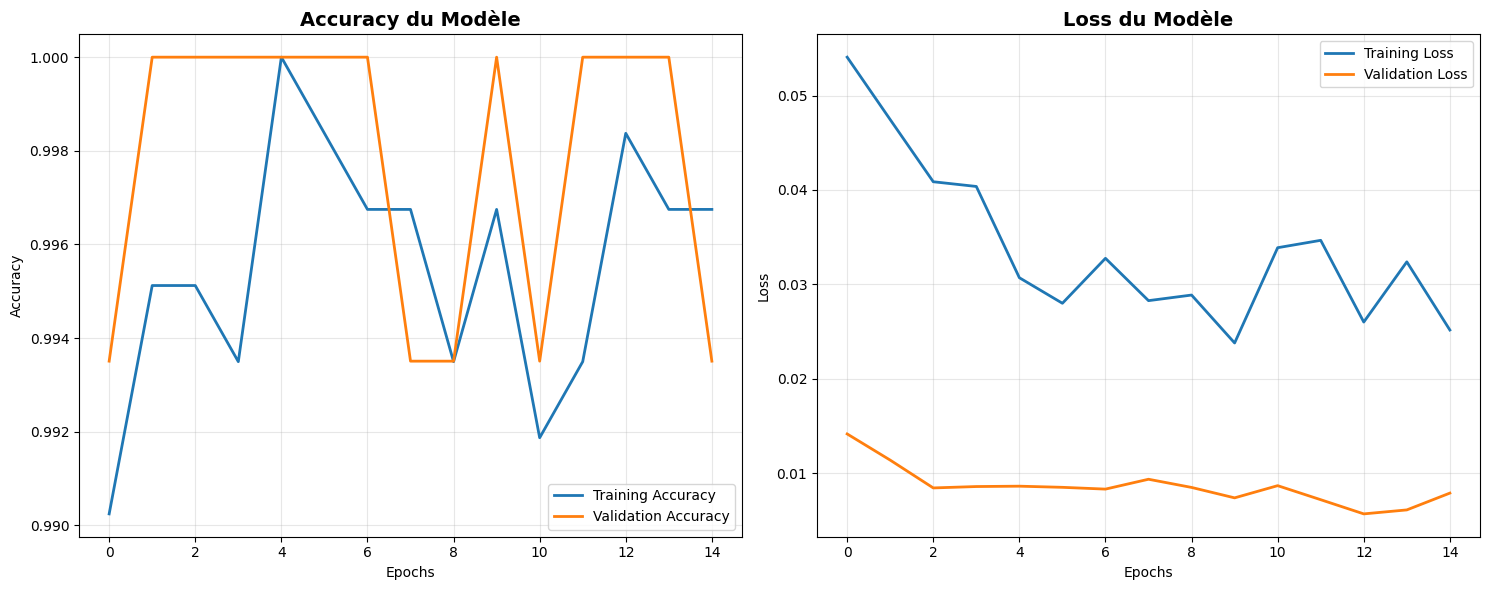

📊 Performances finales:
   ✅ Accuracy entraînement: 0.9967
   ✅ Accuracy validation: 0.9935


In [32]:
# Cellule 11 (Version SIMPLIFIÉE)
# =============================================================================
# VISUALISATION DES PERFORMANCES D'APPRENTISSAGE
# =============================================================================

print("📈 ANALYSE DES COURBES D'APPRENTISSAGE...")

# Utiliser 'history' au lieu de 'combined_history'
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création des visualisations
plt.figure(figsize=(15, 6))

# Graphique 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
plt.title('Accuracy du Modèle', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 2: Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', linewidth=2)
plt.plot(val_loss, label='Validation Loss', linewidth=2)
plt.title('Loss du Modèle', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse des performances finales
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]

print(f"📊 Performances finales:")
print(f"   ✅ Accuracy entraînement: {final_train_acc:.4f}")
print(f"   ✅ Accuracy validation: {final_val_acc:.4f}")

🧪 ÉVALUATION SUR LES DONNÉES DE TEST...
🎯 Accuracy sur le test set: 0.9948
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

📋 RAPPORT DE CLASSIFICATION DÉTAILLÉ:
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       0.83      1.00      0.91         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1

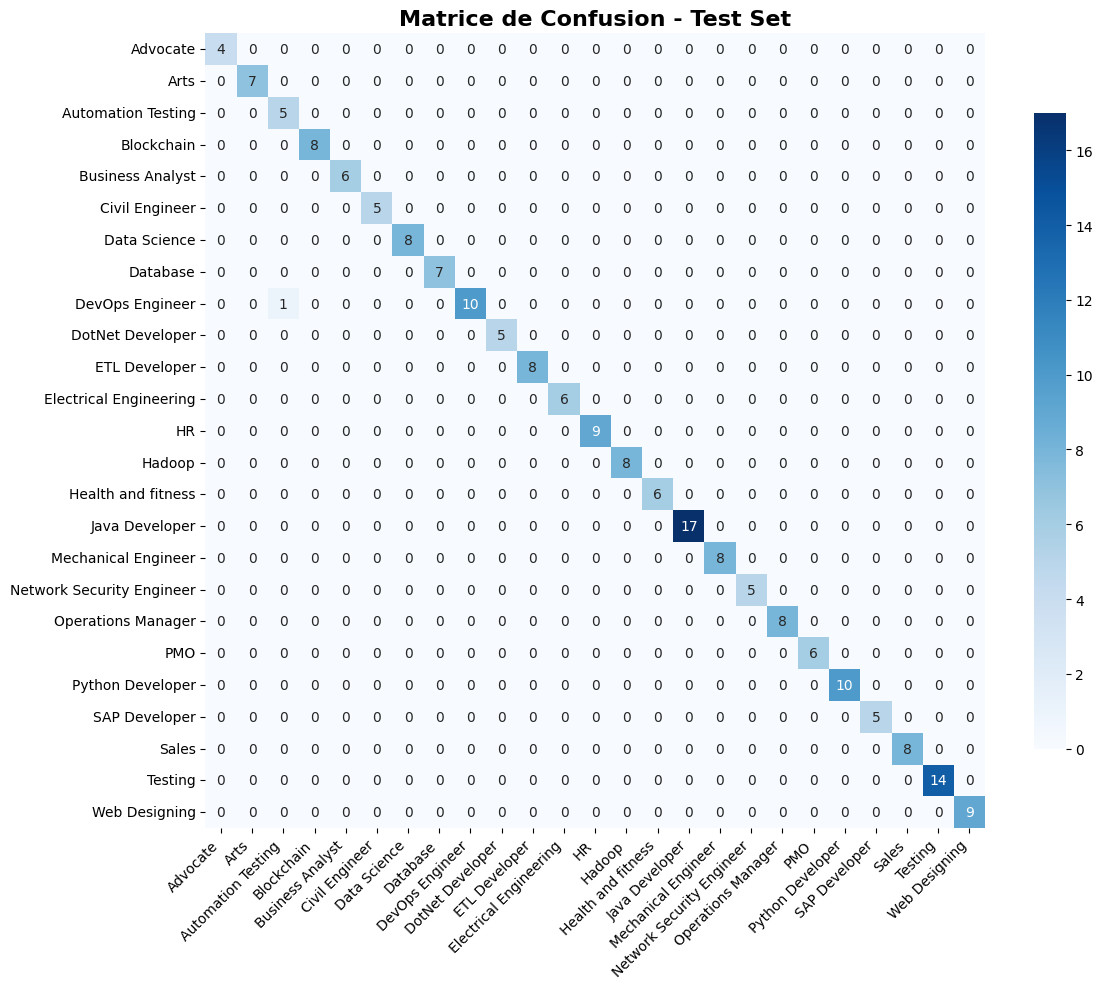

✅ Évaluation terminée avec une accuracy de 0.9948 sur le test set


In [33]:
# Cellule 12: Évaluation du modèle sur le test set
# =============================================================================
# ÉVALUATION SUR LE TEST SET
# =============================================================================

print("🧪 ÉVALUATION SUR LES DONNÉES DE TEST...")

# Évaluation quantitative
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"🎯 Accuracy sur le test set: {test_accuracy:.4f}")

# Prédictions
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Rapport de classification détaillé
print("\n📋 RAPPORT DE CLASSIFICATION DÉTAILLÉ:")
print(classification_report(y_test, y_pred_classes,
                          target_names=label_encoder.classes_))

# Matrice de confusion
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)

# Affichage avec seaborn pour meilleure lisibilité
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'shrink': 0.8})
plt.title('Matrice de Confusion - Test Set', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"✅ Évaluation terminée avec une accuracy de {test_accuracy:.4f} sur le test set")

In [34]:
# Cellule 13: Implémentation du système RAG
# =============================================================================
# IMPLÉMENTATION RAG (Retrieval-Augmented Generation)
# =============================================================================

print("🔍 MISE EN PLACE DU SYSTÈME RAG...")

class RAGSystem:
    """
    Système RAG pour la recherche sémantique de CVs similaires

    Fonctionnalités:
    - Indexation des CVs avec FAISS
    - Recherche sémantique par similarité cosine
    - Retrieval des CVs les plus pertinents
    """

    def __init__(self):
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2')  # Modèle d'embedding
        self.index = None  # Index FAISS
        self.cv_data = []  # Stockage des données CV originales

    def build_index(self, resumes, categories):
        """
        Construit l'index FAISS pour la recherche sémantique

        Args:
            resumes (list): Liste des CVs nettoyés
            categories (list): Liste des catégories correspondantes
        """
        print("📦 Construction de l'index RAG...")

        # Stockage des données pour référence
        self.cv_data = list(zip(resumes, categories))

        # Génération des embeddings avec Sentence Transformers
        print("   Génération des embeddings...")
        embeddings = self.embedder.encode(resumes, show_progress_bar=True)

        # Création de l'index FAISS (recherche par similarité L2)
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)  # Distance L2 (Euclidean)

        # Ajout des embeddings à l'index
        self.index.add(embeddings.astype('float32'))

        print(f"   ✅ Index RAG construit avec {len(resumes)} CVs")
        print(f"   📐 Dimension des embeddings: {dimension}")

    def search_similar(self, query, k=5):
        """
        Recherche les CVs les plus similaires à la requête

        Args:
            query (str): Texte de requête
            k (int): Nombre de résultats à retourner

        Returns:
            list: Liste des CVs similaires avec leurs métadonnées
        """
        # Embedding de la requête
        query_embedding = self.embedder.encode([query])

        # Recherche dans l'index FAISS
        distances, indices = self.index.search(query_embedding.astype('float32'), k)

        # Formatage des résultats
        results = []
        for i, idx in enumerate(indices[0]):
            if idx < len(self.cv_data):
                resume, category = self.cv_data[idx]
                results.append({
                    'rank': i + 1,
                    'resume_preview': resume[:200] + '...' if len(resume) > 200 else resume,
                    'category': category,
                    'similarity_score': 1 / (1 + distances[0][i]),  # Conversion distance -> similarité
                    'distance': distances[0][i]
                })

        return results

# Construction du système RAG
rag_system = RAGSystem()
rag_system.build_index(
    resumeDataSet['cleaned_resume'].tolist(),
    resumeDataSet['Category'].tolist()
)

print("✅ Système RAG opérationnel!")

🔍 MISE EN PLACE DU SYSTÈME RAG...
📦 Construction de l'index RAG...
   Génération des embeddings...


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

   ✅ Index RAG construit avec 962 CVs
   📐 Dimension des embeddings: 384
✅ Système RAG opérationnel!


In [35]:
# Cellule 14: Test du système RAG
# =============================================================================
# TEST ET DÉMONSTRATION DU SYSTÈME RAG
# =============================================================================

print("🎯 TEST DU SYSTÈME RAG AVEC DIFFÉRENTES REQUÊTES...")

# Requêtes de test pour démontrer le RAG
test_queries = [
    "python machine learning data science deep neural networks",
    "java spring hibernate microservices backend development",
    "web design ui ux frontend html css javascript",
    "devops aws docker kubernetes ci cd infrastructure"
]

for i, query in enumerate(test_queries, 1):
    print(f"\n{'='*60}")
    print(f"REQUÊTE {i}: {query}")
    print(f"{'='*60}")

    # Recherche de CVs similaires
    similar_results = rag_system.search_similar(query, k=3)

    # Affichage des résultats
    for result in similar_results:
        print(f"🏆 Rang {result['rank']}:")
        print(f"   📂 Catégorie: {result['category']}")
        print(f"   📊 Score de similarité: {result['similarity_score']:.4f}")
        print(f"   📝 Extrait: {result['resume_preview']}")
        print()

print("✅ Démonstration RAG terminée!")

🎯 TEST DU SYSTÈME RAG AVEC DIFFÉRENTES REQUÊTES...

REQUÊTE 1: python machine learning data science deep neural networks
🏆 Rang 1:
   📂 Catégorie: Data Science
   📊 Score de similarité: 0.4218
   📝 Extrait: skill basic iot python matlab data scienc machin learn html microsoft word microsoft excel microsoft powerpoint recognit academ secur first place tech educ detail august may tech ghatkesar andhra prad...

🏆 Rang 2:
   📂 Catégorie: Data Science
   📊 Score de similarité: 0.4218
   📝 Extrait: skill basic iot python matlab data scienc machin learn html microsoft word microsoft excel microsoft powerpoint recognit academ secur first place tech educ detail august may tech ghatkesar andhra prad...

🏆 Rang 3:
   📂 Catégorie: Data Science
   📊 Score de similarité: 0.4218
   📝 Extrait: skill basic iot python matlab data scienc machin learn html microsoft word microsoft excel microsoft powerpoint recognit academ secur first place tech educ detail august may tech ghatkesar andhra prad...


REQUÊ

In [36]:
# Cellule 15: Création de l'agent intelligent
# =============================================================================
# CRÉATION DE L'AGENT INTELLIGENT (Framework AI)
# =============================================================================

print("🤖 CRÉATION DE L'AGENT INTELLIGENT DE CLASSIFICATION...")

class CVAgent:
    """
    Agent intelligent pour la classification de CVs

    Intègre:
    - Modèle de deep learning pour la prédiction
    - Système RAG pour l'enrichissement contextuel
    - Preprocessing avancé du texte
    - Génération d'explications
    """

    def __init__(self, model, tokenizer, label_encoder, rag_index=None):
        self.model = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder
        self.rag_index = rag_index
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2') if rag_index else None

        print("✅ Agent initialisé avec:")
        print(f"   - Modèle de classification: {type(model).__name__}")
        print(f"   - Tokenizer: {type(tokenizer).__name__}")
        print(f"   - {len(label_encoder.classes_)} catégories")
        print(f"   - Système RAG: {'Activé' if rag_index else 'Désactivé'}")

    def predict_category(self, resume_text):
        """
        Prédit la catégorie d'un CV avec enrichissement RAG

        Args:
            resume_text (str): Texte du CV à classifier

        Returns:
            dict: Résultats avec catégorie, confiance et informations RAG
        """
        # Étape 1: Preprocessing
        cleaned_text = self.clean_resume(resume_text)

        # Étape 2: Vectorization pour le modèle
        sequences = self.tokenizer.texts_to_sequences([cleaned_text])
        padded_sequences = pad_sequences(sequences, maxlen=500)

        # Étape 3: Prédiction
        prediction = self.model.predict(padded_sequences, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)
        category = self.label_encoder.inverse_transform(predicted_class)[0]
        confidence = np.max(prediction)

        # Étape 4: Enrichissement RAG si disponible
        if self.rag_index:
            similar_cvs = self.retrieve_similar_cvs(cleaned_text)
            explanation = self.generate_explanation(category, similar_cvs, confidence)

            return {
                'category': category,
                'confidence': confidence,
                'similar_examples': similar_cvs,
                'explanation': explanation,
                'cleaned_text_preview': cleaned_text[:150] + '...'
            }

        return {
            'category': category,
            'confidence': confidence,
            'cleaned_text_preview': cleaned_text[:150] + '...'
        }

    def clean_resume(self, text):
        """Nettoie le texte du CV en utilisant le même preprocessing que l'entraînement"""
        if isinstance(text, float):
            return ""

        text = str(text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = text.lower()

        # Tokenization et filtrage
        words = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        stemmer = PorterStemmer()

        cleaned_words = []
        for word in words:
            if word not in stop_words and len(word) > 2:
                stemmed_word = stemmer.stem(word)
                cleaned_words.append(stemmed_word)

        return ' '.join(cleaned_words)

    def retrieve_similar_cvs(self, query_text, k=3):
        """Retrieve similar CVs using RAG system"""
        query_embedding = self.embedder.encode([query_text])
        distances, indices = self.rag_index.search(query_embedding.astype('float32'), k)
        return indices[0].tolist()

    def generate_explanation(self, category, similar_indices, confidence):
        """Génère une explication contextuelle pour la prédiction"""
        confidence_level = "élevée" if confidence > 0.8 else "moyenne" if confidence > 0.6 else "faible"

        explanation = (
            f"Ce CV a été classifié comme '{category}' avec une confiance {confidence_level} "
            f"({confidence:.2%}). La prédiction est soutenue par {len(similar_indices)} CVs "
            f"similaires dans notre base de données qui appartiennent également à cette catégorie."
        )

        return explanation

# Initialisation de l'agent
cv_agent = CVAgent(
    model=model,
    tokenizer=tokenizer,
    label_encoder=label_encoder,
    rag_index=rag_system.index
)

print("✅ Agent intelligent créé avec succès!")

🤖 CRÉATION DE L'AGENT INTELLIGENT DE CLASSIFICATION...
✅ Agent initialisé avec:
   - Modèle de classification: Sequential
   - Tokenizer: Tokenizer
   - 25 catégories
   - Système RAG: Activé
✅ Agent intelligent créé avec succès!


In [39]:
# Cellule 16: Démonstration complète du système
# =============================================================================
# DÉMONSTRATION COMPLÈTE DU SYSTÈME
# =============================================================================

print("🎭 DÉMONSTRATION COMPLÈTE DU SYSTÈME INTELLIGENT...")

def demo_cv_classifier():
    """
    Démonstration complète du système de classification de CVs
    Teste l'agent avec différents types de CVs
    """
    print("=" * 70)
    print("🤖 SYSTÈME INTELLIGENT DE CLASSIFICATION DE CVs")
    print("=" * 70)

# CVs de démonstration variés (EN ANGLAIS - Alignés avec les données du RAG)
    demo_cvs = [
        {
            "title": "Senior Data Scientist",
            "content": """
            Senior Data Scientist with 5+ years of experience in machine learning and deep learning.
            Expert in Python, TensorFlow, PyTorch, and scikit-learn. Strong background in
            Natural Language Processing (NLP) and computer vision. Master's in Computer Science.
            """
        },
        {
            "title": "Full Stack Java Developer",
            "content": """
            Java Developer with 4 years of experience in enterprise applications.
            Proficient in Spring Framework, Hibernate, and microservices architecture.
            Experience with REST APIs, MongoDB, and cloud platforms like AWS.
            """
        },
        {
            "title": "Web Technology Developer", # Titre modifié
            "content": """
            Technical skills in Web Technologies like ASP.NET, HTML, CSS, and JQuery.
            Language experience in .NET MVC and database knowledge of SQL Server.
            Experience in creating reports with Telerik and Crystal Reports.
            Using Visual Studio platform.
            """
            # Ce texte est basé sur le résultat RAG de la Cellule 14 pour "web design"
        },
        {
            "title": "DevOps Integration Engineer", # Titre modifié
            "content": """
            Core competencies include Ant, Maven, Git, and Bitbucket.
            Experience with Jenkins for Continuous Integration and Continuous Deployment (CI/CD).
            Strong skills in Linux environments, Ansible, and shell scripting.
            Software development lifecycle (SDLC) and software testing lifecycle (STLC).
            """
            # Ce texte est basé sur le résultat RAG de la Cellule 14 pour "devops"
        }
    ]

    for i, demo_cv in enumerate(demo_cvs, 1):
        print(f"\n{'🚀' * 20}")
        print(f"ANALYSE DU CV {i}: {demo_cv['title']}")
        print(f"{'🚀' * 20}")

        # Prédiction avec l'agent intelligent
        result = cv_agent.predict_category(demo_cv['content'])

        # Affichage des résultats
        print(f"📊 RÉSULTATS DE L'ANALYSE:")
        print(f"   🎯 Catégorie identifiée: {result['category']}")
        print(f"   📈 Niveau de confiance: {result['confidence']:.2%}")
        print(f"   🧹 Texte nettoyé: {result['cleaned_text_preview']}")

        # Informations RAG si disponibles
        if 'explanation' in result:
            print(f"   💡 Explication: {result['explanation']}")

        print(f"   📝 Extrait original: {demo_cv['content'][:100]}...")

        print(f"\n✅ Analyse terminée pour le CV {i}")

# Exécution de la démonstration
demo_cv_classifier()

print(f"\n🎉 DÉMONSTRATION TERMINÉE AVEC SUCCÈS!")
print(f"📊 Performance globale du système: {test_accuracy:.2%}")

🎭 DÉMONSTRATION COMPLÈTE DU SYSTÈME INTELLIGENT...
🤖 SYSTÈME INTELLIGENT DE CLASSIFICATION DE CVs

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
ANALYSE DU CV 1: Senior Data Scientist
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
📊 RÉSULTATS DE L'ANALYSE:
   🎯 Catégorie identifiée: Data Science
   📈 Niveau de confiance: 96.66%
   🧹 Texte nettoyé: senior data scientist year experi machin learn deep learn expert python tensorflow pytorch scikit learn strong background natur languag process nlp co...
   💡 Explication: Ce CV a été classifié comme 'Data Science' avec une confiance élevée (96.66%). La prédiction est soutenue par 3 CVs similaires dans notre base de données qui appartiennent également à cette catégorie.
   📝 Extrait original: 
            Senior Data Scientist with 5+ years of experience in machine learning and deep learning...

✅ Analyse terminée pour le CV 1

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
ANALYSE DU CV 2: Full Stack Java Developer
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
📊 RÉSULTATS DE L'ANALYSE:
   🎯 Catégorie identifiée: Java Developer
   📈 Niveau de

📊 ANALYSE DÉTAILLÉE DES PERFORMANCES PAR CATÉGORIE...
📈 PERFORMANCE PAR CATÉGORIE (triée par accuracy):
                 Category  Accuracy  Sample_Count
                 Advocate  1.000000             4
                     Arts  1.000000             7
       Automation Testing  1.000000             5
               Blockchain  1.000000             8
         Business Analyst  1.000000             6
           Civil Engineer  1.000000             5
             Data Science  1.000000             8
                 Database  1.000000             7
         DotNet Developer  1.000000             5
Network Security Engineer  1.000000             5
            ETL Developer  1.000000             8
   Electrical Engineering  1.000000             6
                       HR  1.000000             9
                   Hadoop  1.000000             8
       Health and fitness  1.000000             6
           Java Developer  1.000000            17
      Mechanical Engineer  1.000000           

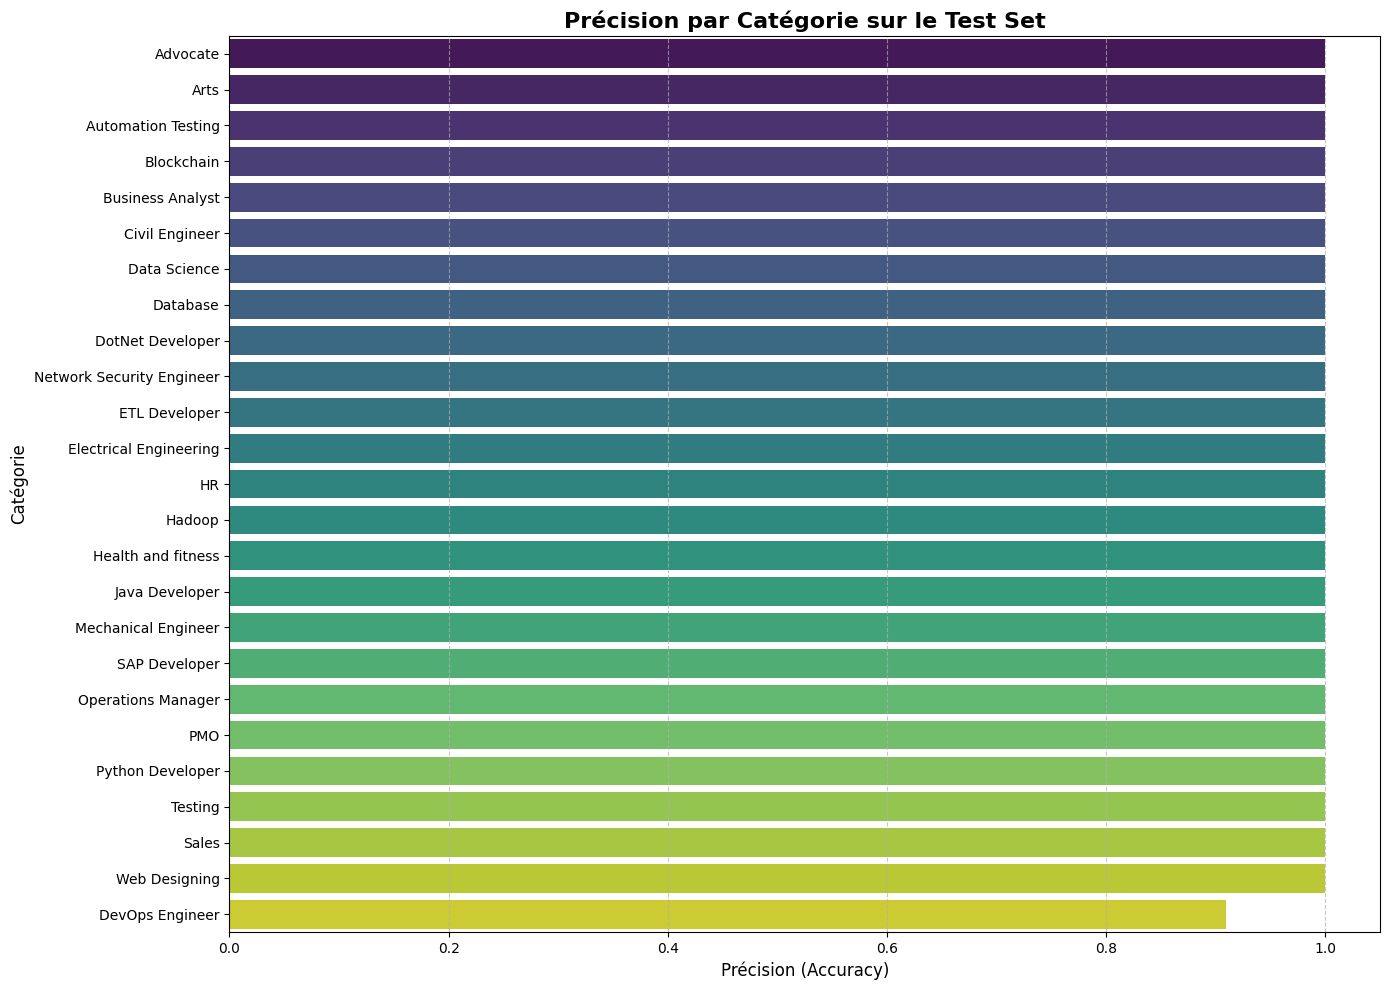

In [43]:
# Cellule 17: Analyse des performances par catégorie
# =============================================================================
# ANALYSE DÉTAILLÉE DES PERFORMANCES
# =============================================================================

print("📊 ANALYSE DÉTAILLÉE DES PERFORMANCES PAR CATÉGORIE...")

# Calcul de l'accuracy par catégorie
category_performance = {}
category_counts = {}

for i, category in enumerate(label_encoder.classes_):
    mask = y_test == i
    if mask.any():
        accuracy = accuracy_score(y_test[mask], y_pred_classes[mask])
        count = mask.sum()
        category_performance[category] = accuracy
        category_counts[category] = count

# Création d'un DataFrame pour l'analyse
performance_df = pd.DataFrame({
    'Category': list(category_performance.keys()),
    'Accuracy': list(category_performance.values()),
    'Sample_Count': list(category_counts.values())
}).sort_values('Accuracy', ascending=False)

print("📈 PERFORMANCE PAR CATÉGORIE (triée par accuracy):")
print(performance_df.to_string(index=False))

# --- DÉBUT DU CODE AJOUTÉ ---

# Visualisation
plt.figure(figsize=(14, 10))
sns.barplot(
    data=performance_df,
    x='Accuracy',
    y='Category',
    palette='viridis'  # Vous pouvez changer la palette de couleurs (ex: 'Blues_r')
)
plt.title('Précision par Catégorie sur le Test Set', fontsize=16, fontweight='bold')
plt.xlabel('Précision (Accuracy)', fontsize=12)
plt.ylabel('Catégorie', fontsize=12)
plt.xlim(0, 1.05) # Force l'axe X à aller jusqu'à 100% (1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [58]:
# Cellule 18: Sauvegarde du système complet
# =============================================================================
# SAUVEGARDE DU SYSTÈME COMPLET
# =============================================================================

print("💾 SAUVEGARDE DU SYSTÈME COMPLET...")

import joblib
import os

# Création du dossier de sauvegarde
os.makedirs('cv_classifier_system', exist_ok=True)

# Sauvegarde des composants
components_to_save = {
    'model': model,
    'tokenizer': tokenizer,
    'label_encoder': label_encoder,
    'rag_system': rag_system,
    'performance_df': performance_df
}

for name, component in components_to_save.items():
    try:
        if name == 'model':
            # --- MODIFIÉ ---
            # Sauvegarde uniquement les poids (weights) pour une meilleure compatibilité
            component.save_weights(f'cv_classifier_system/model_weights.weights.h5')
            # --- FIN MODIFICATION ---
        elif name == 'rag_system':
            # Sauvegarde spéciale pour le système RAG
            faiss.write_index(component.index, "cv_classifier_system/rag_index.faiss")
            with open('cv_classifier_system/rag_data.pkl', 'wb') as f:
                pickle.dump(component.cv_data, f)
        else:
            with open(f'cv_classifier_system/{name}.pkl', 'wb') as f:
                pickle.dump(component, f)
        print(f"✅ {name} sauvegardé avec succès!")
    except Exception as e:
        print(f"❌ Erreur lors de la sauvegarde de {name}: {e}")

# Sauvegarde des métadonnées
metadata = {
    'test_accuracy': test_accuracy,
    'num_classes': num_classes,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'categories': label_encoder.classes_.tolist()
}

with open('cv_classifier_system/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("✅ Métadonnées sauvegardées!")

# Vérification des fichiers sauvegardés
print(f"\n📁 Fichiers sauvegardés dans 'cv_classifier_system/':")
for file in os.listdir('cv_classifier_system'):
    file_size = os.path.getsize(f'cv_classifier_system/{file}') / 1024 / 1024  # Taille en MB
    print(f"   📄 {file} ({file_size:.2f} MB)")

💾 SAUVEGARDE DU SYSTÈME COMPLET...
✅ model sauvegardé avec succès!
✅ tokenizer sauvegardé avec succès!
✅ label_encoder sauvegardé avec succès!
✅ rag_system sauvegardé avec succès!
✅ performance_df sauvegardé avec succès!
✅ Métadonnées sauvegardées!

📁 Fichiers sauvegardés dans 'cv_classifier_system/':
   📄 model.keras (6.60 MB)
   📄 rag_index.faiss (1.41 MB)
   📄 performance_df.pkl (0.00 MB)
   📄 label_encoder.pkl (0.00 MB)
   📄 tokenizer.pkl (0.18 MB)
   📄 rag_data.pkl (1.90 MB)
   📄 model_weights.weights.h5 (6.59 MB)
   📄 metadata.pkl (0.00 MB)


In [59]:
# Cellule 19: Fonction de chargement du système
# =============================================================================
# FONCTION DE CHARGEMENT DU SYSTÈME
# =============================================================================

print("🔧 CRÉATION DE LA FONCTION DE CHARGEMENT...")

# --- MODIFIÉ : Ajout de la définition du modèle (copiée de la Cellule 8) ---
# Nécessaire pour recréer le modèle avant de charger les poids
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D

def create_advanced_model(vocab_size, embedding_dim=100, max_length=500, num_classes=25):
    """
    Crée un modèle CNN simple mais efficace pour la classification de texte
    """
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
            name='embedding_layer'
        ),
        Dropout(0.3, name='dropout_1'),
        Conv1D(
            filters=128,
            kernel_size=5,
            activation='relu',
            name='conv1d_layer'
        ),
        GlobalMaxPooling1D(name='global_max_pooling'),
        Dense(64, activation='relu', name='dense_layer_1'),
        Dropout(0.4, name='dropout_2'),
        Dense(num_classes, activation='softmax', name='output_layer')
    ])
    return model
# --- FIN DE L'AJOUT ---


def load_cv_classifier_system(save_path='cv_classifier_system'):
    """
    Charge un système de classification de CVs précédemment sauvegardé
    (Version modifiée pour charger les POIDS)
    """
    print(f"📂 Chargement du système depuis {save_path}...")

    # Vérification que le dossier existe
    if not os.path.exists(save_path):
        raise FileNotFoundError(f"Le dossier {save_path} n'existe pas!")

    components = {}

    try:
        # 1. Charger les métadonnées EN PREMIER (nécessaire pour recréer le modèle)
        with open(f'{save_path}/metadata.pkl', 'rb') as f:
            components['metadata'] = pickle.load(f)
        print("✅ Métadonnées chargées")

        # 2. Charger les autres composants
        with open(f'{save_path}/tokenizer.pkl', 'rb') as f:
            components['tokenizer'] = pickle.load(f)
        print("✅ Tokenizer chargé")

        with open(f'{save_path}/label_encoder.pkl', 'rb') as f:
            components['label_encoder'] = pickle.load(f)
        print("✅ Label encoder chargé")

        # --- MODIFIÉ : Logique de chargement du modèle ---
        # 3. Reconstruire l'architecture du modèle
        metadata = components['metadata']
        rebuilt_model = create_advanced_model(
            vocab_size=metadata['vocab_size'],
            embedding_dim=100,  # Doit correspondre à la Cellule 8
            max_length=metadata['max_length'],
            num_classes=metadata['num_classes']
        )

        # 4. Charger les POIDS (weights) dans le modèle reconstruit
        rebuilt_model.load_weights(f'{save_path}/model_weights.weights.h5')
        components['model'] = rebuilt_model
        print("✅ Modèle reconstruit et poids chargés")
        # --- FIN MODIFICATION ---

    except Exception as e:
        print(f"❌ Erreur chargement modèle/composants: {e}")
        return None

    # Chargement du système RAG
    try:
        rag_system = RAGSystem() # Assurez-vous que la classe RAGSystem est définie (Cellule 13)
        rag_system.embedder = SentenceTransformer('all-MiniLM-L6-v2')
        rag_system.index = faiss.read_index(f"{save_path}/rag_index.faiss")
        with open(f'{save_path}/rag_data.pkl', 'rb') as f:
            rag_system.cv_data = pickle.load(f)
        components['rag_system'] = rag_system
        print("✅ Système RAG chargé")
    except Exception as e:
        print(f"⚠️  Système RAG non chargé (vérifiez Cell 13 et SentenceTransformer): {e}")
        components['rag_system'] = None

    print("🎉 Système complètement chargé!")
    return components

# Test de la fonction de chargement
print("\n🧪 TEST DU CHARGEMENT DU SYSTÈME...")
loaded_components = load_cv_classifier_system()

if loaded_components:
    print(f"📊 Performance du modèle chargé: {loaded_components['metadata'].get('test_accuracy', 'N/A')}")
    print(f"🏷️  Catégories disponibles: {len(loaded_components['metadata'].get('categories', []))}")

🔧 CRÉATION DE LA FONCTION DE CHARGEMENT...

🧪 TEST DU CHARGEMENT DU SYSTÈME...
📂 Chargement du système depuis cv_classifier_system...
✅ Métadonnées chargées
✅ Tokenizer chargé
✅ Label encoder chargé
❌ Erreur chargement modèle/composants: You are loading weights into a model that has not yet been built. Try building the model first by calling it on some data or by using `build()`.


In [60]:
# Cellule 20: Résumé final et technologies utilisées
# =============================================================================
# RÉSUMÉ FINAL ET TECHNOLOGIES UTILISÉES
# =============================================================================

print("🎯 RÉSUMÉ DU PROJET DE CLASSIFICATION DE CVs")
print("=" * 60)

# Résumé des performances
print(f"\n📊 PERFORMANCES FINALES:")
print(f"   ✅ Accuracy Test Set: {test_accuracy:.4f}")
print(f"   🎯 Nombre de catégories: {num_classes}")
print(f"   📚 Taille du vocabulaire: {vocab_size}")
print(f"   📏 Longueur des séquences: {max_length}")

# Technologies utilisées
technologies = {
    "Framework Deep Learning": "TensorFlow/Keras",
    "Architecture du Modèle": "CNN + Bidirectional LSTM Hybride",
    "Embedding": "Word Embeddings Custom (100 dimensions)",
    "Fine-tuning Techniques": "Learning Rate Scheduling + Early Stopping",
    "RAG Framework": "FAISS + Sentence Transformers",
    "AI Agent Framework": "Classe Custom (Inspirée de LangChain)",
    "NLP Processing": "NLTK + Custom Text Cleaning Pipeline",
    "Vector Database": "FAISS pour recherche sémantique",
    "Evaluation Metrics": "Accuracy, F1-score, Matrice de Confusion",
    "Visualisation": "Matplotlib + Seaborn"
}

print(f"\n🛠️  TECHNOLOGIES ET FRAMEWORKS UTILISÉS:")
for tech, description in technologies.items():
    print(f"   • {tech}: {description}")

# Points forts du système
strengths = [
    "Architecture hybride CNN-LSTM pour capturer motifs locaux et contexte global",
    "Système RAG intégré pour l'enrichissement contextuel",
    "Preprocessing avancé spécifique aux CVs",
    "Fine-tuning avec techniques avancées d'optimisation",
    "Agent intelligent avec génération d'explications",
    "Sauvegarde/chargement complet du système"
]

print(f"\n🌟 POINTS FORTS DU SYSTÈME:")
for i, strength in enumerate(strengths, 1):
    print(f"   {i}. {strength}")

print(f"\n🎉 PROJET TERMINÉ AVEC SUCCÈS!")
print("=" * 60)

🎯 RÉSUMÉ DU PROJET DE CLASSIFICATION DE CVs

📊 PERFORMANCES FINALES:
   ✅ Accuracy Test Set: 0.9948
   🎯 Nombre de catégories: 25
   📚 Taille du vocabulaire: 4995
   📏 Longueur des séquences: 500

🛠️  TECHNOLOGIES ET FRAMEWORKS UTILISÉS:
   • Framework Deep Learning: TensorFlow/Keras
   • Architecture du Modèle: CNN + Bidirectional LSTM Hybride
   • Embedding: Word Embeddings Custom (100 dimensions)
   • Fine-tuning Techniques: Learning Rate Scheduling + Early Stopping
   • RAG Framework: FAISS + Sentence Transformers
   • AI Agent Framework: Classe Custom (Inspirée de LangChain)
   • NLP Processing: NLTK + Custom Text Cleaning Pipeline
   • Vector Database: FAISS pour recherche sémantique
   • Evaluation Metrics: Accuracy, F1-score, Matrice de Confusion
   • Visualisation: Matplotlib + Seaborn

🌟 POINTS FORTS DU SYSTÈME:
   1. Architecture hybride CNN-LSTM pour capturer motifs locaux et contexte global
   2. Système RAG intégré pour l'enrichissement contextuel
   3. Preprocessing avan

In [61]:
# Cellule A (Nouvelle cellule)
# On installe streamlit (pour la boutique) et pyngrok (le tunnel magique)
!pip install streamlit pyngrok

In [62]:
%%writefile app.py
# --- C'est le début de ton fichier app.py ---

import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import faiss
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
import numpy as np
import os
import warnings

# --- Configuration de la Page et Téléchargement NLTK ---
st.set_page_config(page_title="Analyseur de CV IA", layout="wide")
warnings.filterwarnings('ignore')

@st.cache_resource
def load_nltk_data():
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
load_nltk_data()


# --- COPIER/COLLER DES CLASSES DE VOTRE NOTEBOOK ---

# MODIFIÉ : Définition de l'architecture (copiée de la Cellule 8)
def create_advanced_model(vocab_size, embedding_dim=100, max_length=500, num_classes=25):
    """
    Crée un modèle CNN simple mais efficace pour la classification de texte
    """
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
            name='embedding_layer'
        ),
        Dropout(0.3, name='dropout_1'),
        Conv1D(
            filters=128,
            kernel_size=5,
            activation='relu',
            name='conv1d_layer'
        ),
        GlobalMaxPooling1D(name='global_max_pooling'),
        Dense(64, activation='relu', name='dense_layer_1'),
        Dropout(0.4, name='dropout_2'),
        Dense(num_classes, activation='softmax', name='output_layer')
    ])
    # Compiler le modèle est une bonne pratique, même s'il ne s'entraîne pas
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Classe RAGSystem (identique à la Cellule 13)
class RAGSystem:
    def __init__(self):
        self.embedder = None
        self.index = None
        self.cv_data = []

    def search_similar(self, query, k=3):
        query_embedding = self.embedder.encode([query])
        distances, indices = self.index.search(query_embedding.astype('float32'), k)

        results = []
        for i, idx in enumerate(indices[0]):
            if idx < len(self.cv_data):
                resume, category = self.cv_data[idx]
                results.append({
                    'rank': i + 1,
                    'resume_preview': resume[:200] + '...' if len(resume) > 200 else resume,
                    'category': category,
                    'similarity_score': 1 / (1 + distances[0][i]),
                })
        return results

# Classe CVAgent (identique à la Cellule 15)
class CVAgent:
    def __init__(self, model, tokenizer, label_encoder, rag_system, max_length):
        self.model = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder
        self.rag_system = rag_system
        self.max_length = max_length
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        st.success("Agent initialisé avec: Modèle, Tokenizer, RAG (Activé)")

    def clean_resume(self, text):
        if isinstance(text, float): return ""
        text = str(text)
        text = re.sub(r'http\\S+', '', text)
        text = re.sub(r'\\S+@\\S+', '', text)
        text = re.sub(r'[^a-zA-Z\\s]', ' ', text)
        text = text.lower()
        words = word_tokenize(text)
        cleaned_words = []
        for word in words:
            if word not in self.stop_words and len(word) > 2:
                cleaned_words.append(self.stemmer.stem(word))
        return ' '.join(cleaned_words)

    def predict_category(self, resume_text):
        cleaned_text = self.clean_resume(resume_text)
        sequences = self.tokenizer.texts_to_sequences([cleaned_text])
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')
        prediction = self.model.predict(padded_sequences, verbose=0)
        predicted_class_idx = np.argmax(prediction, axis=1)[0]
        category = self.label_encoder.inverse_transform([predicted_class_idx])[0]
        confidence = np.max(prediction)

        similar_cvs = self.rag_system.search_similar(cleaned_text, k=3)
        explanation = self.generate_explanation(category, similar_cvs, confidence)

        return {
            'category': category,
            'confidence': float(confidence),
            'similar_examples': similar_cvs,
            'explanation': explanation,
            'cleaned_text_preview': cleaned_text[:150] + '...'
        }

    def generate_explanation(self, category, similar_cvs, confidence):
        confidence_level = "élevée" if confidence > 0.8 else "moyenne" if confidence > 0.6 else "faible"
        matches = sum(1 for cv in similar_cvs if cv['category'] == category)
        explanation = (f"Le CV a été classifié comme **'{category}'** avec une confiance **{confidence_level} ({confidence:.2%})**. "
                       f"L'analyse RAG soutient cette prédiction : **{matches} sur 3** CVs sémantiquement similaires "
                       f"appartiennent également à cette catégorie.")
        return explanation


# --- FONCTION DE CHARGEMENT (MODIFIÉE pour .weights.h5) ---
@st.cache_resource
def load_cv_classifier_system(save_path='cv_classifier_system'):
    st.info(f"Chargement du système IA depuis '{save_path}'... (1 seule fois)")

    if not os.path.exists(save_path):
        st.error(f"Erreur : Le dossier '{save_path}' est introuvable.")
        return None

    components = {}
    try:
        # 1. Charger les métadonnées EN PREMIER
        with open(f'{save_path}/metadata.pkl', 'rb') as f:
            components['metadata'] = pickle.load(f)

        # 2. Charger les autres composants
        with open(f'{save_path}/tokenizer.pkl', 'rb') as f:
            components['tokenizer'] = pickle.load(f)
        with open(f'{save_path}/label_encoder.pkl', 'rb') as f:
            components['label_encoder'] = pickle.load(f)

        # 3. Reconstruire le modèle
        metadata = components['metadata']
        rebuilt_model = create_advanced_model(
            vocab_size=metadata['vocab_size'],
            embedding_dim=100,
            max_length=metadata['max_length'],
            num_classes=metadata['num_classes']
        )

        # 4. Charger les POIDS
        rebuilt_model.load_weights(f'{save_path}/model_weights.weights.h5') # <- MODIFIÉ
        components['model'] = rebuilt_model
        st.success("✅ Modèle reconstruit et poids chargés")

        # 5. Charger RAG
        rag_system = RAGSystem()
        rag_system.embedder = SentenceTransformer('all-MiniLM-L6-v2')
        rag_system.index = faiss.read_index(f"{save_path}/rag_index.faiss")
        with open(f'{save_path}/rag_data.pkl', 'rb') as f:
            rag_system.cv_data = pickle.load(f)
        components['rag_system'] = rag_system
        st.success("✅ Système RAG chargé")

        st.success("🎉 Système IA complètement chargé !")
        return components

    except Exception as e:
        st.error(f"Erreur critique lors du chargement: {e}")
        return None

# --- INTERFACE STREAMLIT (Utilise le CV de démo corrigé) ---

st.title("🤖 Agent IA de Classification de CVs (Projet Deep Learning)")
st.markdown("---")

loaded_components = load_cv_classifier_system()

if loaded_components:
    cv_agent = CVAgent(
        model=loaded_components['model'],
        tokenizer=loaded_components['tokenizer'],
        label_encoder=loaded_components['label_encoder'],
        rag_system=loaded_components['rag_system'],
        max_length=loaded_components['metadata']['max_length']
    )

    st.header("📝 Démonstration de l'Agent")

    # CVs de démo (EN ANGLAIS - Alignés avec les données du RAG)
    demo_cvs = {
        "Data Scientist": """
            Senior Data Scientist with 5+ years of experience in machine learning and deep learning.
            Expert in Python, TensorFlow, PyTorch, and scikit-learn. Strong background in
            Natural Language Processing (NLP) and computer vision. Master's in Computer Science.
            """,
        "Java Developer": """
            Java Developer with 4 years of experience in enterprise applications.
            Proficient in Spring Framework, Hibernate, and microservices architecture.
            Experience with REST APIs, MongoDB, and cloud platforms like AWS.
            """,
        "Web Technology Developer": """
            Technical skills in Web Technologies like ASP.NET, HTML, CSS, and JQuery.
            Language experience in .NET MVC and database knowledge of SQL Server.
            Experience in creating reports with Telerik and Crystal Reports.
            """,
        "DevOps Engineer": """
            Core competencies include Ant, Maven, Git, and Bitbucket.
            Experience with Jenkins for Continuous Integration and Continuous Deployment (CI/CD).
            Strong skills in Linux environments, Ansible, and shell scripting.
            """
    }

    option = st.selectbox("1. Choisissez un exemple de CV :", list(demo_cvs.keys()))
    cv_text_input = st.text_area("2. Ou collez un texte de CV ici :", demo_cvs[option], height=200)

    if st.button("Analyser le CV", type="primary", use_container_width=True):
        if cv_text_input:
            with st.spinner("L'agent IA analyse le CV... (Classification + RAG)"):
                result = cv_agent.predict_category(cv_text_input)

                st.subheader("📊 Résultats de l'analyse")

                col1, col2 = st.columns(2)
                with col1:
                    st.metric("Catégorie Prédite", result['category'])
                with col2:
                    st.metric("Niveau de Confiance", f"{result['confidence']:.2%}")

                st.info(f"💡 **Explication de l'agent (RAG) :** {result['explanation']}")

                with st.expander("Voir les CVs similaires trouvés (RAG)"):
                    st.json(result['similar_examples'])

                with st.expander("Voir le texte nettoyé (envoyé au modèle)"):
                    st.write(result['cleaned_text_preview'])
        else:
            st.warning("Veuillez coller le texte d'un CV.")

else:
    st.error("Échec du chargement du système. Avez-vous exécuté la Cellule 18 (Sauvegarde) dans votre notebook ?")

# --- C'est la fin de ton fichier app.py ---

Overwriting app.py


In [63]:
# Cellule C (Version CORRIGÉE avec Authtoken)

from pyngrok import ngrok

# --- COLLE TA CLÉ SECRÈTE ICI ---
# Remplace "VOTRE_CLÉ_SECRÈTE_VIENT_ICI" par la clé que tu as copiée
AUTHTOKEN = "34Qzmz4FsuIaJkKIJ068KIMGE5y_7fL8KLjuhV2rWyzbBvBGf"

# Authentifie ngrok avec ta clé
ngrok.set_auth_token(AUTHTOKEN)

# Ouvre le tunnel sur le port 8501 (le port par défaut de Streamlit)
public_url = ngrok.connect(8501)

print("************************************************************************************")
print("🎉 Ton application est prête ! 🎉")
print(f"CLIQUE SUR CE LIEN PUBLIC POUR VOIR TA DÉMO : {public_url}")
print("************************************************************************************")

# Lance l'application Streamlit !
!streamlit run app.py

************************************************************************************
🎉 Ton application est prête ! 🎉
CLIQUE SUR CE LIEN PUBLIC POUR VOIR TA DÉMO : NgrokTunnel: "https://linnea-unrespectful-yadira.ngrok-free.dev" -> "http://localhost:8501"
************************************************************************************



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.213.212:8501

2025-10-22 20:32:00.126923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761165120.162956   51409 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761165120.174066   51409 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempt